# # 모듈 및 함수
---

In [1]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import json
import os
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import sys
import cv2
import random
import open3d as o3d


## 2D 함수 ##
def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    x = np.array(x).reshape(1, -1)
    y = np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    y = list(y.reshape(-1))
    return y


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    x = np.array(x).reshape(1, -1)
    y = np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    y = list(y.reshape(-1))
    return y


def xyxy2xywhn(x, w=1920, h=1200, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    if clip:
        clip_boxes(x, (h - eps, w - eps))  # warning: inplace clip
    x = np.array(x).reshape(1, -1)
    y = np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    y = list(y.reshape(-1))
    return y


def kitti_to_yolo(label, x1, y1, x2, y2, image_w, image_h): # x1=x_min, y1=y_min, x2=x_max, y2=y_max
    return [label, ((x2 + x1)/(2*image_w)), ((y2 + y1)/(2*image_h)), (x2 - x1)/image_w, (y2 - y1)/image_h]


## 3D 함수 ##
import copy
import numpy as np
import os
import sys
import cv2
import random


def inverse_rigid_trans(Tr):
    ''' Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    '''
    inv_Tr = np.zeros_like(Tr) # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr


class Calibration(object):
    ''' Calibration matrices and utils
        3d XYZ in <label>measure are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.

        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref

        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]

        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)

        velodyne coord:
        front x, left y, up z

        rect/ref camera coord:
        right x, down y, front z

        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf

        TODO(rqi): do matrix multiplication only once for each projection.
    '''

    def __init__(self, calib_filepath):
        with open(calib_filepath) as f:
            self.P0 = np.fromstring(f.readline().split(":")[1], sep=" ").reshape((3, 4))
            self.P1 = np.fromstring(f.readline().split(":")[1], sep=" ").reshape((3, 4))

            # Projection matrix from rectified camera coord to image2/3 coord
            self.P2 = np.fromstring(f.readline().split(":")[1], sep=" ").reshape((3, 4))
            self.P3 = np.fromstring(f.readline().split(":")[1], sep=" ").reshape((3, 4))

            # Rotation from reference camera coord to rectified camera coord
            line = f.readline()
            self.R0_rect = np.fromstring(line[line.index(" "):], sep=" ").reshape((3, 3))

            # Rigid transform from lidar coord to reference camera coord
            line = f.readline()
            self.Tr_lidar_to_cam = np.fromstring(line[line.index(" "):], sep=" ").reshape((3, 4))  # lidar_to_cam
            self.Tr_cam_to_lidar = inverse_rigid_trans(self.Tr_lidar_to_cam)                       # cam_to_lidar

            line = f.readline()
            self.Tr_imu_to_lidar = np.fromstring(line[line.index(" "):], sep=" ").reshape((3, 4))  # imu_to_lidar
            self.Tr_lidar_to_imu = inverse_rigid_trans(self.Tr_imu_to_lidar)                       # lidar_to_imu

    def cart2hom(self, pts_3d):
        ''' Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        '''
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    def inverse_rigid_trans(Tr):
        ''' Inverse a rigid body transform matrix (3x4 as [R|t])
            [R'|-R't; 0|1]
        '''
        inv_Tr = np.zeros_like(Tr)  # 3x4
        inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
        inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
        return inv_Tr
    
    
class TransformationKitti(Calibration):
    # ===========================
    # ------- 3d to 3d ----------
    # ===========================
    def __init__(self, calib_file):
        super().__init__(calib_file)

    def project_lidar_to_ref(self, pts_3d_lidar):
        pts_3d_lidar = self.cart2hom(pts_3d_lidar)  # nx4
        return np.dot(pts_3d_lidar, np.transpose(self.Tr_lidar_to_cam))

    def project_imu_to_lidar(self, pts_3d_imu):
        ''' Input: nx3 points in lidar coord.
            Output: nx3 points in IMU coord.
        '''
        pts_3d_imu = self.cart2hom(pts_3d_imu)  # nx4
        return np.dot(pts_3d_imu, np.transpose(self.Tr_imu_to_lidar))


    def project_lidar_to_imu(self, pts_3d_lidar):
        ''' Input: nx3 points in lidar coord.
            Output: nx3 points in IMU coord.
        '''
        pts_3d_lidar = self.cart2hom(pts_3d_lidar)  # nx4
        return np.dot(pts_3d_lidar, np.transpose(self.self.Tr_lidar_to_imu))


    def project_ref_to_lidar(self, pts_3d_ref):
        pts_3d_ref = self.cart2hom(pts_3d_ref)  # nx4
        return np.dot(pts_3d_ref, np.transpose(self.self.Tr_cam_to_lidar))


    def project_rect_to_ref(self, pts_3d_rect):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(np.linalg.inv(self.R0_rect), np.transpose(pts_3d_rect)))


    def project_ref_to_rect(self, pts_3d_ref):
        '''
        Input and Output are nx3 points
        '''
        # pts_3d_ref = Tr_lidar_to_cam * [x y z 1]
        return np.transpose(np.dot(self.R0_rect, np.transpose(pts_3d_ref)))  # R0_rect_rect * Tr_lidar_to_cam * A

    def project_rect_to_lidaro(self, pts_3d_rect):
        ''' Input: nx3 points in rect camera coord.
            Output: nx3 points in lidar coord.
        '''
        pts_3d_ref = self.project_rect_to_ref(pts_3d_rect)
        return self.project_ref_to_lidar(pts_3d_ref)


    def project_lidar_to_rect(self, pts_3d_lidar):
        pts_3d_ref = self.project_lidar_to_ref(pts_3d_lidar)
        return self.project_ref_to_rect(pts_3d_ref)

    # ===========================
    # ------- 3d to 2d ----------
    # ===========================

    def project_rect_to_image(self, pts_3d_rect):
        '''
            Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        '''
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(
            self.P2))  # nx3     P_rect_2 * R0_rect_rect *Tr_lidar_to_cam * A
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        x1y1, x2y2 = np.min(pts_2d[:, 0:2], axis=0).tolist(), np.max(pts_2d[:, 0:2], axis=0).tolist()
        pts_2d_img = x1y1 + x2y2
        for idx, value in enumerate(pts_2d_img):
            if value <= 0:
                pts_2d_img[idx] = 0
            if value >= 1241:
                pts_2d_img[idx] = 1241
        return pts_2d_img

    def project_3d_to_image(self, pts_3d_rect):
        '''
            Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        '''
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P2))  # nx3     P_rect_2 * R0_rect_rect *Tr_lidar_to_cam * A
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:,0:2]

    def project_lidar_to_image(self, pts_3d_lidar):
        ''' Input: nx3 points in lidar coord.
            Output: nx3 points in image2 coord.
        '''
        pts_3d_rect = self.project_lidar_to_rect(pts_3d_lidar)
        return self.project_rect_to_image(pts_3d_rect)

    # ===========================
    # ------- 2d to 3d ----------
    # ===========================
    def project_image_to_rect(self, uv_depth):
        ''' Input: nx3 first two channels are uv, 3rd channel
                   is depth in rect camera coord.
            Output: nx3 points in rect camera coord.
        '''
        n = uv_depth.shape[0]
        x = ((uv_depth[:, 0] - self.c_u) * uv_depth[:, 2]) / self.f_u + self.b_x
        y = ((uv_depth[:, 1] - self.c_v) * uv_depth[:, 2]) / self.f_v + self.b_y
        pts_3d_rect = np.zeros((n, 3))
        pts_3d_rect[:, 0] = x
        pts_3d_rect[:, 1] = y
        pts_3d_rect[:, 2] = uv_depth[:, 2]
        return pts_3d_rect

    def project_image_to_lidar(self, uv_depth):
        pts_3d_rect = self.project_image_to_rect(uv_depth)
        return self.project_rect_to_lidar(pts_3d_rect)


def roty(t):
    ''' Rotation about the y-axis. '''
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, 0, s],
                     [0, 1, 0],
                     [-s, 0, c]])


def convert_3dbox_to_8corner(bbox3d_input):
    ''' Takes an object's 3D box with the representation of [h,w,l, x,y,z,theta] and
        convert it to the 8 corners of the 3D box

        Returns:
            corners_3d: (8,3) array in in rect camera coord
    '''
    # compute rotational matrix around yaw axis
    bbox3d = copy.copy(bbox3d_input)

    R = roty(bbox3d[6])

    # 3d bounding box dimensions
    l = bbox3d[2]
    w = bbox3d[1]
    h = bbox3d[0]

    # 3d bounding box corners
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2];
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h];
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2];

    # rotate and translate 3d bounding box
    corners_3d = np.dot(R, np.vstack(
        [x_corners, y_corners, z_corners]))  # np.vstack([x_corners,y_corners,z_corners])
    # print corners_3d.shape
    corners_3d[0, :] = corners_3d[0, :] + bbox3d[3]  # x
    corners_3d[1, :] = corners_3d[1, :] + bbox3d[4]  # y
    corners_3d[2, :] = corners_3d[2, :] + bbox3d[5]  # z

    a = np.transpose(corners_3d)
    return np.transpose(corners_3d)


def compute_box_3dto2d(bbox3d_input, calib_file):
    ''' Takes an object and a projection matrix (P) and projects the 3d
        bounding box into the image plane.
        Returns:
            corners_2d: (8,2) array in left image coord.
            corners_3d: (8,3) array in in rect camera coord.
    '''
    # compute rotational matrix around yaw axis
    bbox3d = copy.copy(bbox3d_input)

    R = roty(bbox3d[6])

    # 3d bounding box dimensions
    l = bbox3d[2]
    w = bbox3d[1]
    h = bbox3d[0]

    # 3d bounding box corners
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2];
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h];
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2];

    # rotate and translate 3d bounding box
    corners_3d = np.dot(R, np.vstack(
        [x_corners, y_corners, z_corners]))
    # print corners_3d.shape
    corners_3d[0, :] = corners_3d[0, :] + bbox3d[3]  # x
    corners_3d[1, :] = corners_3d[1, :] + bbox3d[4]  # y
    corners_3d[2, :] = corners_3d[2, :] + bbox3d[5]  # z
    # if np.any(corners_3d[2, :] < 0.1):
    #     corners_2d = None
    #     return corners_2d
    corners_3d = np.transpose(corners_3d)
    corners_2d = TransformationKitti(calib_file).project_3d_to_image(corners_3d)
    return corners_2d


def convert_x1y1x2y2_to_xywh(bbox):
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w / 2.
    y = bbox[1] + h / 2.
    s = w * h  # scale is just area
    r = w / float(h)
    return np.array([x, y, w, h]).tolist()


def convert_x1y1x2y2_to_tlwh(bbox):
    '''
    :param bbox: x1 y1 x2 y2
    :return: tlwh: top_left x   top_left y    width   height
    '''
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    return np.array(([bbox[0], bbox[1], w, h]))
    

def draw_projected_box3d(image, qs, color=(255,255,255), thickness=2):
    ''' Draw 3d bounding box in image
        qs: (8,2) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''
    if qs is not None:
        qs = qs.astype(np.int32)
        for k in range(0,4):
           i,j=k,(k+1)%4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness) # use LINE_AA for opencv3

           i,j=k+4,(k+1)%4 + 4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)

           i,j=k,k+4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)
    return image


def show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file, label=None, line_thickness=3):
    img2 = cv2.imread(img2)
    box3d_pts_2d = compute_box_3dto2d(bbox3d_tmp, calib_file)
    tl = line_thickness or round(0.002 * (img2.shape[0] + img2.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    if box3d_pts_2d is not None:
        c1, c2 = (int(box3d_pts_2d[4, 0]), int(box3d_pts_2d[4, 1])),  (int(box3d_pts_2d[3, 0]), int(box3d_pts_2d[3, 1]))
    else:
        c1, c2 = (0,0), (0,0)
    color_tmp = color
    img2 = draw_projected_box3d(img2, box3d_pts_2d, color=color_tmp)
    # if box3d_pts_2d is not None:
    #     img2 = cv2.putText(img2, label, (int(box3d_pts_2d[4, 0]), int(box3d_pts_2d[4, 1]) - 8),
    #                        cv2.FONT_HERSHEY_TRIPLEX, 0.5, color=color_tmp)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(str(label), 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img2, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img2, str(label), (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    
    b, g, r = cv2.split(img2)
    img = cv2.merge([r,g,b])
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # cv2.imwrite(image_path + "/" + "{}.png".format(img0_name), img2)
    
    # global bbox3d_2d
    # bbox3d_2d = []
    # bbox3d_2d.append(box3d_pts_2d)
    # img.save(save_path)
    # print('--')
    
# max_color = 30
# score_threshold = -10000
# width = 1920
# height = 1200
# bbox3d_2d = []

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# # 2D
---

In [ ]:
path = '/data/NIA50/yolov5/runs/detect/sample_front/'
imgs = sorted(os.listdir(path))[:-1]

for img in imgs:
    display(Image.open(path+img))

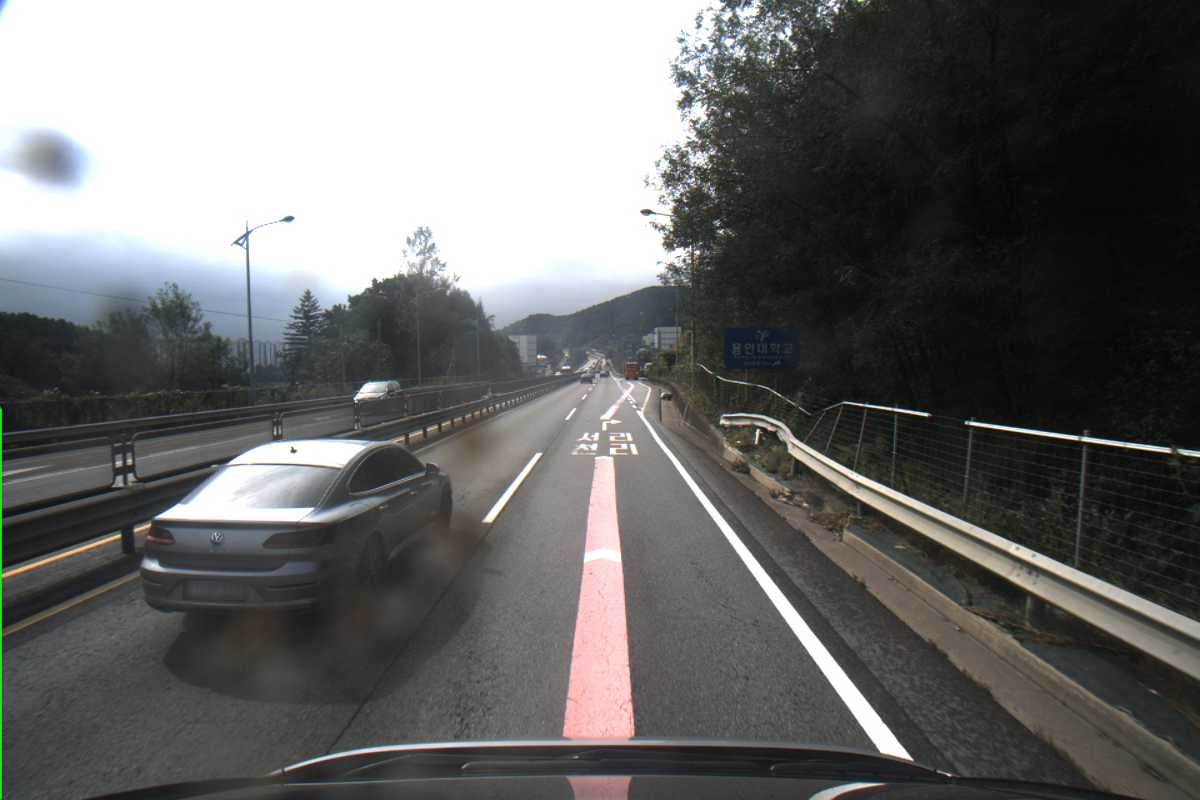

In [5]:
path = f'/data/NIA50/50-2/data/NIA48/temp_data/images/2-048_21470_017.png'

# with open('/data/NIA50/data/nia48/training/label_2/test48.txt', 'r') as f:
#     box = f.read().split(' ')[4:8]
#     box = list(map(float, box))
box = [
                        -134.34525542302015,
                        905.3343068321783,
                        -268.6905108460403,
                        589.3313863356433
                    ]
img = Image.open(path).convert('RGB')
draw = ImageDraw.Draw(img)
color = (0, 255, 0)
draw.rectangle(xywh2xyxy(box), outline = color, width = 3)

display(img.resize(size=(1200, 800)))

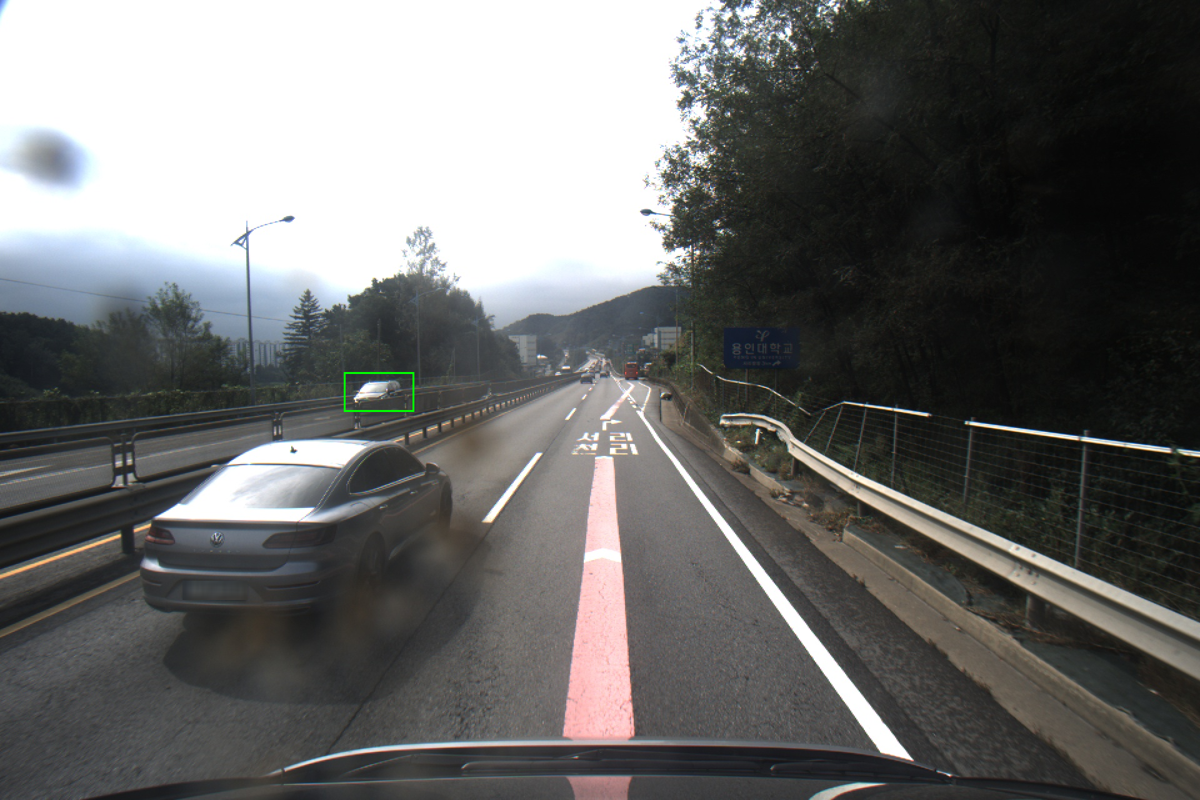

In [6]:
path = f'/data/NIA50/50-2/data/NIA48/temp_data/images/2-048_21470_017.png'

# with open('/data/NIA50/data/nia48/training/label_2/test48.txt', 'r') as f:
#     box = f.read().split(' ')[4:8]
#     box = list(map(float, box))
box = [
                        606.6716340396058,
                        587.8588316093147,
                        112.55093108019366,
                        59.20702257051721
                    ],
img = Image.open(path).convert('RGB')
draw = ImageDraw.Draw(img)
color = (0, 255, 0)
draw.rectangle(xywh2xyxy(box), outline = color, width = 3)

display(img.resize(size=(1200, 800)))

In [ ]:
path = f'/data/NIA48/S_Clip_02244_02/Camera/CameraFront/blur/2-048_02244_CF_001.png'

with open('/data/NIA50/data/nia48/training/label_2/test48.txt', 'r') as f:
    box = f.read().split(' ')[4:8]
    box = list(map(float, box))
img = Image.open(path).convert('RGB')
draw = ImageDraw.Draw(img)
color = (0, 255, 0)
draw.rectangle(xywh2xyxy(box), outline = color, width = 3)

display(img.resize(size=(1200, 800)))

In [ ]:
path = f'/data/hwang/datasets/kitti/training/image_2/000038.png'

with open('/data/hwang/datasets/kitti/training/label_2/000038.txt', 'r') as f:
    box = f.read().split(' ')[4:8]
    box = list(map(float, box))
img = Image.open(path).convert('RGB')
draw = ImageDraw.Draw(img)
color = (0, 255, 0)
draw.rectangle(box, outline = color, width = 3)

display(img)

# # 3D
---

## # 3D to 2D
---

In [ ]:
from scipy.spatial.transform import Rotation as R

# 문자열 숫자리스트로 바꾸는 함수
def str2list(txt):
    txt = txt.replace('\n', '').split(',')
    txt = list(map(float, txt))
    
    return txt


# 리스트를 문자열로 바꾸는 함수
def list2str(list):
    list = ' '.join(map(str, list))
    
    return list


In [ ]:
with open('/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/calib/Suwon_A_0000_copy_0000.txt') as f:
    calib = f.readlines()
    
eulerangle = str2list(calib[4])
rotation_matrix = R.from_euler('xyz', eulerangle, degrees=True).as_matrix()
# e_rotation_matrix = np.matmul(essential_matrix, rotation_matrix)
# e_rotation_matrix = np.matmul(rotation_matrix, essential_matrix)
translation = str2list(calib[6])
fpd = str2list(calib[8])
intrinsic = np.asarray([fpd[0], 0, fpd[2], 0,
                        0, fpd[1], fpd[3], 0,
                        0, 0, 1, 0]).reshape(3,4)
extrinsic = np.hstack([rotation_matrix, np.asarray(translation).reshape(3, -1)])

p2 = intrinsic.reshape(-1).tolist()
R0_rect = np.eye(3).reshape(-1).tolist()
Tr_velo_to_cam = extrinsic.reshape(-1).tolist()
Tr_imu_to_velo = np.zeros((12)).tolist()

calib_kitti =  ['P0: '+list2str(p2), 
                'P1: '+list2str(p2), 
                'P2: '+list2str(p2), 
                'P3: '+list2str(p2), 
                'R0_rect: '+list2str(R0_rect), 
                'Tr_velo_to_cam: '+list2str(Tr_velo_to_cam), 
                'Tr_imu_to_velo: '+list2str(Tr_imu_to_velo)]

with open(f'/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/calib/Suwon_A_0000_copy_0000.txt', 'w') as f:
    f.write('\n'.join(calib_kitti))



img2 = '/data/NIA50/50-2/data/NIA50_samples/Suwon_A_0000_copy/camera/camera_0/0000.jpg'
with open('/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/label_2/Suwon_A_0000_copy_0000.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
    # bbox3d_tmp[4:7] * 
    # bbox3d_tmp[-1] = -18 * np.pi/180
image_path = '.'
color = (0, 255, 0)
img0_name = 'test'
calib_file = '/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/calib/Suwon_A_0000_copy_0000.txt'

show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file)

compute_box_3dto2d(bbox3d_tmp, calib_file)

In [ ]:
img2 = '/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/Camera/CameraFront/blur/2-048_02244_CF_001.png'
with open('/data/NIA50/50-2/data/NIA48/training/label_2/test48.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
    # bbox3d_tmp[4:7] * 
    # bbox3d_tmp[-1] += 90 * np.pi/180
image_path = '.'
color = (0, 255, 0)
img0_name = 'test'
calib_file = '/data/NIA50/50-2/data/NIA48/training/calib/test48.txt'

show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file)

compute_box_3dto2d(bbox3d_tmp, calib_file)

In [ ]:
img2 = '/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02369_02/Camera/CameraFront/blur/2-048_02369_CF_001.png'
with open('/data/NIA50/50-2/data/NIA48/training/label_2/test48.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
    # bbox3d_tmp[4:7] * 
    # bbox3d_tmp[-1] += 90 * np.pi/180
image_path = '.'
color = (0, 255, 0)
img0_name = 'test'
calib_file = '/data/NIA50/50-2/data/NIA48/training/calib/test48.txt'

show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file)

compute_box_3dto2d(bbox3d_tmp, calib_file)

In [ ]:
img2 = '/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02345_02/Camera/CameraFront/blur/2-048_02345_CF_001.png'
with open('/data/NIA50/50-2/data/NIA48/training/label_2/test48.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
    # bbox3d_tmp[4:7] * 
    # bbox3d_tmp[-1] += 90 * np.pi/180
image_path = '.'
color = (0, 255, 0)
img0_name = 'test'
calib_file = '/data/NIA50/50-2/data/NIA48/training/calib/test48.txt'

show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file)

compute_box_3dto2d(bbox3d_tmp, calib_file)

In [ ]:
img2 = '/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02324_02/Camera/CameraFront/blur/2-048_02324_CF_001.png'
with open('/data/NIA50/50-2/data/NIA48/training/label_2/test48.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
    # bbox3d_tmp[4:7] * 
    # bbox3d_tmp[-1] += 90 * np.pi/180
image_path = '.'
color = (0, 255, 0)
img0_name = 'test'
calib_file = '/data/NIA50/50-2/data/NIA48/training/calib/test48.txt'

show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file)

compute_box_3dto2d(bbox3d_tmp, calib_file)

In [ ]:
img2 = '/data/hwang/datasets/kitti/training/image_2/000050.png'
with open('/data/hwang/datasets/kitti/training/label_2/000050.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
image_path = '.'
color = (0, 255, 0)
img0_name = 'test'
calib_file = '/data/hwang/datasets/kitti/training/calib/000050.txt'

show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file)

compute_box_3dto2d(bbox3d_tmp, calib_file)

In [ ]:
img2 = '/data/hwang/datasets/kitti/training/image_2/000037.png'
with open('/data/hwang/datasets/kitti/training/label_2/000037.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
image_path = '.'
color = (0, 255, 0)
img0_name = 'test'
calib_file = '/data/hwang/datasets/kitti/training/calib/000037.txt'

show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, calib_file)

compute_box_3dto2d(bbox3d_tmp, calib_file)

## # PCD
---

In [ ]:
import pandas as pd
import json

with open('/data/NIA50/50-2/data/NIA48/training/label_2/test48.txt') as f:
    bbox3d_tmp = f.readline()
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
    
corners_8 = convert_3dbox_to_8corner(bbox3d_tmp)

xmin = corners_8[:, 0].min()
xmax = corners_8[:, 0].max()
ymin = corners_8[:, 1].min()
ymax = corners_8[:, 1].max()
zmin = corners_8[:, 2].min()
zmax = corners_8[:, 2].max()

pcd_f = o3d.t.io.read_point_cloud('/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/Lidar/2-048_02244_LR_001.pcd')
print(pcd_f)

positions = pcd_f.point.positions.numpy()
intensity = pcd_f.point.intensity.numpy()
points = np.concatenate((positions, intensity), axis = 1)

# points = np.fromfile('/data/hwang/datasets/kitti/training/velodyne/000038.bin', dtype=np.float32).reshape(-1, 4)
points = points[:, :3]

# points = np_pcd_file[:, :3]
print("points.shape: ", points.shape)
# crop the points
crop_x = (xmin, xmax)
crop_y = (ymin, ymax)
crop_z = (zmin, zmax)
# points = points[(points[:, 0] < crop_x[0]) & (points[:, 0] > crop_x[1]) & (points[:, 1] < crop_y[0]) & (points[:, 1] > crop_y[1]) & (points[:, 2] < crop_z[0]) & (points[:, 2] > crop_z[1])]
points_crop = points[(points[:, 0] >= crop_x[0]) & (points[:, 0] <= crop_x[1]) & (points[:, 1] >= crop_y[0]) & (points[:, 1] <= crop_y[1]) & (points[:, 2] >= crop_z[0]) & (points[:, 2] <= crop_z[1])]
print("points_crop.shape: ", points_crop.shape)

max_x, max_y, max_z = np.max(points, axis=0)
min_x, min_y, min_z = np.min(points, axis=0)
print("min_x: ", min_x, "\tmin_y: ", min_y, "\tmin_z: ", min_z)
print("max_x: ", max_x, "\tmax_y: ", max_y, "\tmax_z: ", max_z)
# cmax_x, cmax_y, cmax_z = np.max(points_crop, axis=0)
# cmin_x, cmin_y, cmin_z = np.min(points_crop, axis=0)
# print("cmin_x: ", cmin_x, "\tcmin_y: ", cmin_y, "\tcmin_z: ", cmin_z)
# print("cmax_x: ", cmax_x, "\tcmax_y: ", cmax_y, "\tcmax_z: ", cmax_z)
# print("crop x, y, z: ", crop_x, crop_y, crop_z)

points = np.hstack((points, np.ones((len(points), 1))))
# points_crop = np.hstack((points_crop, np.ones((len(points_crop), 1))))

# view bird's eye view

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# hide axes, set background color to white
# x: left to right, y: front to back, z: bottom to top

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, color='black', s=5)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s = 0.1)
ax.scatter(points_crop[:, 0], points_crop[:, 1], points_crop[:, 2], color='yellow', s = 5)
zoom = 10
ax.set_xlim(-zoom, zoom)
ax.set_ylim(-zoom, zoom)
ax.set_zlim(-zoom, zoom)
ax.set_facecolor('white')
ax.set_axis_off()
plt.show()


points.shape:  (64000, 3)
points_crop.shape:  (0, 3)
min_x:  -16.737146 	min_y:  -143.22697 	min_z:  -13.467164
max_x:  72.51605 	max_y:  147.91098 	max_z:  24.757126


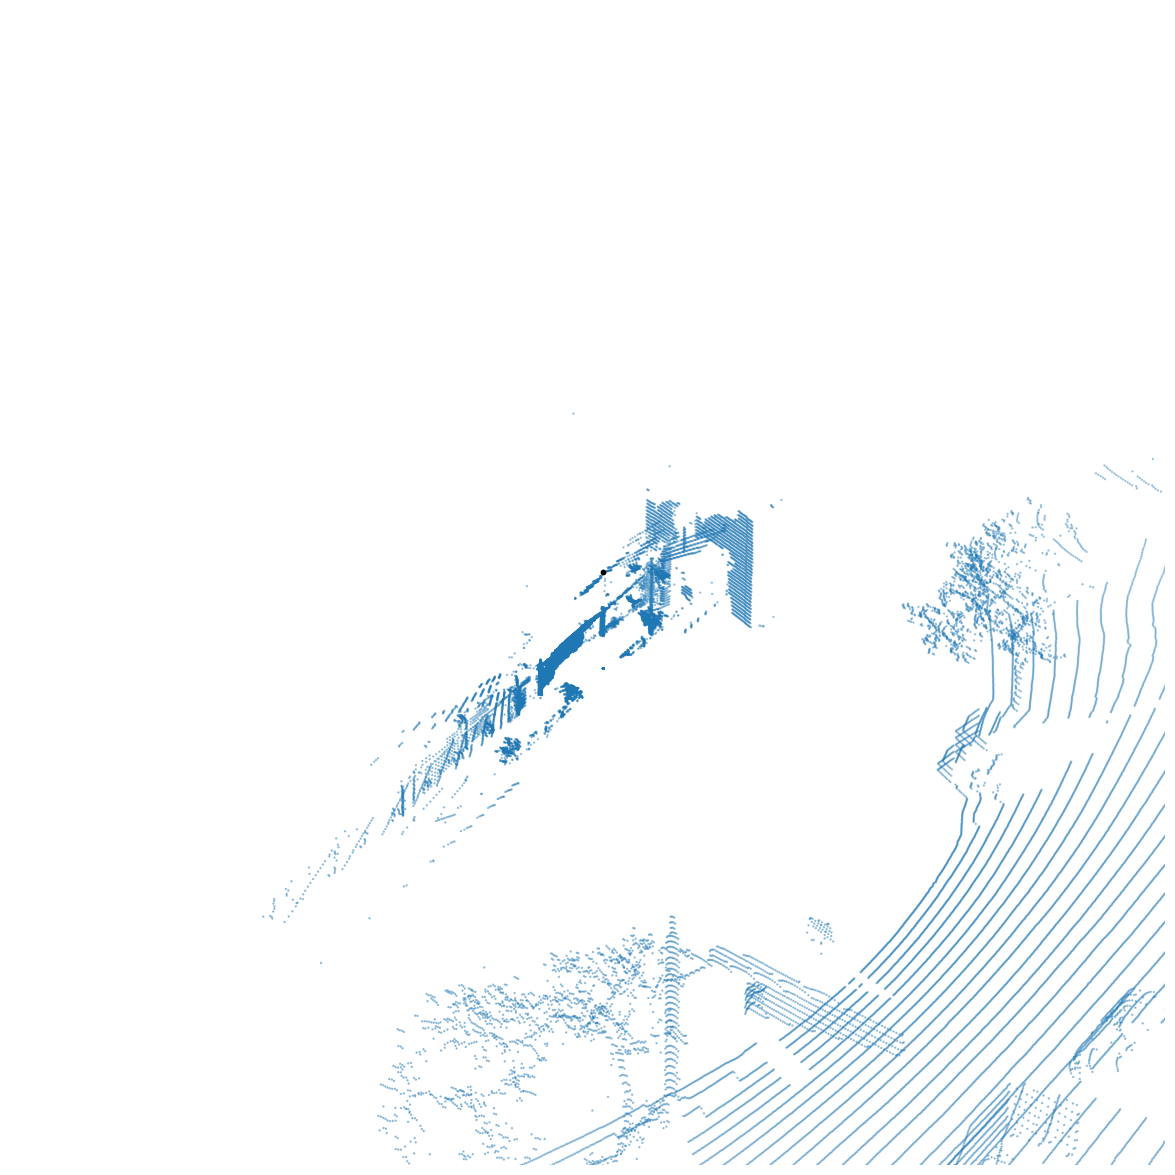

In [11]:
# kitti

import pandas as pd
import json

with open('/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/label_2/Suwon_A_0000_copy_0000.txt') as f:
    bbox3d_tmp = f.readlines()[1]
    bbox3d_tmp = list(map(float, bbox3d_tmp.replace('\n', '').split(' ')[8:]))
    
with open('/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/calib/Suwon_A_0000_copy_0000.txt') as f:
    calib = f.readlines()
    extrinsic = list(map(float, calib[5].replace('\n', '').split(' ')[1:]))
    extrinsic = np.asarray(extrinsic).reshape(3, 4)    
    R0_rect = list(map(float, calib[4].replace('\n', '').split(' ')[1:]))
    R0_rect = np.asarray(R0_rect).reshape(3, 3)

xyz = bbox3d_tmp[3:6]
# xyz = np.asarray([bbox3d_tmp[4], bbox3d_tmp[3], bbox3d_tmp[5]]).reshape(3, 1)
# xyz = np.asarray(bbox3d_tmp[3:6]).reshape(3, 1)
xyz = np.matmul(R0_rect.T, xyz).reshape(-1).tolist()

xyz_1 = np.asarray(xyz + [1]).reshape(4, 1)
bbox3d_tmp[3:6] = np.matmul(inverse_rigid_trans(extrinsic), xyz_1).reshape(-1).tolist()
corners_8 = convert_3dbox_to_8corner(bbox3d_tmp)

xmin = corners_8[:, 0].min()
xmax = corners_8[:, 0].max()
ymin = corners_8[:, 1].min()
ymax = corners_8[:, 1].max()
zmin = corners_8[:, 2].min()
zmax = corners_8[:, 2].max()

pcd_f = o3d.t.io.read_point_cloud('/data/NIA50/SUSTechPOINTS_2-050/data/Suwon_A_0000/lidar/0010.pcd')
positions = pcd_f.point.positions.numpy()
intensity = pcd_f.point.intensity.numpy()
points = np.concatenate((positions, intensity), axis = 1)[:, :3]

# points = np.fromfile('/data/hwang/datasets/kitti/training/velodyne/000000.bin', dtype=np.float32).reshape(-1, 4)
# points = points[:, :3]

print("points.shape: ", points.shape)
# crop the points
crop_x = (xmin, xmax)
crop_y = (ymin, ymax)
crop_z = (zmin, zmax)
# points = points[(points[:, 0] < crop_x[0]) & (points[:, 0] > crop_x[1]) & (points[:, 1] < crop_y[0]) & (points[:, 1] > crop_y[1]) & (points[:, 2] < crop_z[0]) & (points[:, 2] > crop_z[1])]
points_crop = points[(points[:, 0] >= crop_x[0]) & (points[:, 0] <= crop_x[1]) & (points[:, 1] >= crop_y[0]) & (points[:, 1] <= crop_y[1]) & (points[:, 2] >= crop_z[0]) & (points[:, 2] <= crop_z[1])]
print("points_crop.shape: ", points_crop.shape)

max_x, max_y, max_z = np.max(points, axis=0)
min_x, min_y, min_z = np.min(points, axis=0)
print("min_x: ", min_x, "\tmin_y: ", min_y, "\tmin_z: ", min_z)
print("max_x: ", max_x, "\tmax_y: ", max_y, "\tmax_z: ", max_z)
# cmax_x, cmax_y, cmax_z = np.max(points_crop, axis=0)
# cmin_x, cmin_y, cmin_z = np.min(points_crop, axis=0)
# print("cmin_x: ", cmin_x, "\tcmin_y: ", cmin_y, "\tcmin_z: ", cmin_z)
# print("cmax_x: ", cmax_x, "\tcmax_y: ", cmax_y, "\tcmax_z: ", cmax_z)
# print("crop x, y, z: ", crop_x, crop_y, crop_z)

points = np.hstack((points, np.ones((len(points), 1))))
points_crop = np.hstack((points_crop, np.ones((len(points_crop), 1))))

# view bird's eye view

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# hide axes, set background color to white
# x: left to right, y: front to back, z: bottom to top

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s = 0.5)
ax.scatter(points_crop[:, 0], points_crop[:, 1], points_crop[:, 2], color='yellow', s = 10)
ax.scatter(0, 0, 0, color='black', s=10)
ax.scatter(bbox3d_tmp[3], bbox3d_tmp[4], bbox3d_tmp[5], color='black', s=10)

zoom = 10
ax.set_xlim(-zoom, zoom)
ax.set_ylim(-zoom, zoom)
ax.set_zlim(-zoom, zoom)
ax.set_facecolor('white')
ax.set_axis_off()
plt.show()


In [ ]:
import numpy as np
from glob import glob

NP_POINTS_DIR = "/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/points/"

np_pcd_files = sorted(glob(os.path.join(NP_POINTS_DIR, "*.npy")))

idx = 1
np_pcd_file = np_pcd_files[idx]
print(np_pcd_file)

points = np.load(np_pcd_file)[:, :3]
# points = np_pcd_file[:, :3]
print("points.shape: ", points.shape)
# crop the points
# crop_x = (xmin, xmax)
# crop_y = (ymin, ymax)
# crop_z = (zmin, zmax)
points = points[(points[:, 0] < crop_x[0]) & (points[:, 0] > crop_x[1]) & (points[:, 1] < crop_y[0]) & (points[:, 1] > crop_y[1]) & (points[:, 2] < crop_z[0]) & (points[:, 2] > crop_z[1])]
# points_crop = points[(points[:, 0] > crop_x[0]) & (points[:, 0] < crop_x[1]) & (points[:, 1] > crop_y[0]) & (points[:, 1] < crop_y[1]) & (points[:, 2] > crop_z[0]) & (points[:, 2] < crop_z[1])]
# print("points_crop.shape: ", points_crop.shape)

max_x, max_y, max_z = np.max(points, axis=0)
min_x, min_y, min_z = np.min(points, axis=0)
print("min_x: ", min_x, "\tmin_y: ", min_y, "\tmin_z: ", min_z)
print("max_x: ", max_x, "\tmax_y: ", max_y, "\tmax_z: ", max_z)
# cmax_x, cmax_y, cmax_z = np.max(points_crop, axis=0)
# cmin_x, cmin_y, cmin_z = np.min(points_crop, axis=0)
# print("cmin_x: ", cmin_x, "\tcmin_y: ", cmin_y, "\tcmin_z: ", cmin_z)
# print("cmax_x: ", cmax_x, "\tcmax_y: ", cmax_y, "\tcmax_z: ", cmax_z)
# print("crop x, y, z: ", crop_x, crop_y, crop_z)

points = np.hstack((points, np.ones((len(points), 1))))
points_crop = np.hstack((points_crop, np.ones((len(points_crop), 1))))

# view bird's eye view

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# hide axes, set background color to white
# x: left to right, y: front to back, z: bottom to top

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0]*-1, points[:, 1]*-1, points[:, 2], cmap='viridis', s = 0.1)
# ax.scatter(points_crop[:, 0]*-1, points_crop[:, 1]*-1, points_crop[:, 2], cmap='viridis', color='yellow', s = 0.1)
zoom = 8
ax.set_xlim(-zoom, zoom)
ax.set_ylim(-zoom, zoom)
ax.set_zlim(-zoom, zoom)
ax.set_facecolor('white')
ax.set_axis_off()
plt.show()
